# PointNet을 사용한 포인트 클라우드 분류

**저자:** [David Griffiths](https://dgriffiths3.github.io)<br>
**만든 날짜:** 2020/05/25<br>
**최종 수정 날짜:** 2020/05/26<br>
**설명:** ModelNet10 분류를 위한 PointNet 구현.

# 포인트 클라우드 분류


## 소개

정렬되지 않은 3D 포인트 세트, 즉 포인트 클라우드의 분류, 감지 및 세분화는 컴퓨터 비전의 핵심 문제입니다. 이 예제는 획기적인 포인트 클라우드 딥 러닝 페이퍼[PointNet(Qi et al., 2017)](https://arxiv.org/abs/1612.00593)를 구현합니다. PointNet에 대한 자세한 소개는 [이 블로그 게시물](https://ganghee-lee.tistory.com/50)을 참조하십시오.


## 설정

colab을 사용하는 경우 먼저 `!pip install trimesh`와 함께 trimesh를 설치합니다.


In [57]:
!pip install trimesh

In [58]:

import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)


## 데이터세트 로드

ModelNet40 데이터 세트의 더 작은 10개 클래스 버전인 ModelNet10 모델 데이터 세트를 사용합니다. 먼저 데이터를 다운로드합니다.

In [59]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")


'trimesh' 패키지를 사용하여 '.off' 메시 파일을 읽고 시각화할 수 있습니다.


In [60]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()


메쉬 파일을 포인트 클라우드로 변환하려면 먼저 메쉬 표면에서 포인트를 샘플링해야 합니다. `.sample()`은 unifrom 무작위 샘플링을 수행합니다. 여기서 우리는 2048개의 위치에서 샘플링하고 `matplotlib`에서 시각화합니다.


(2048, 3)
[ 9.86872755 -2.39085793 -6.53166088]


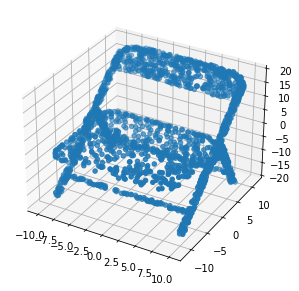

In [80]:
points = mesh.sample(2048)
print(points.shape)
print(points[0])
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
# ax.set_axis_off()
plt.show()


`tf.data.Dataset()`을 생성하려면 먼저 ModelNet 데이터 폴더를 구문 분석해야 합니다. 각 메시는 표준 파이썬 목록에 추가되고 'numpy' 배열로 변환되기 전에 포인트 클라우드에 로드되고 샘플링됩니다. 또한 현재 열거 인덱스 값을 객체 레이블로 저장하고 사전을 사용하여 나중에 호출합니다.


In [46]:

def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = os.path.basename(folder)
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
    print(np.array(train_points).shape)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )



샘플 및 배치 크기에 대한 포인트 수를 설정하고 데이터 세트를 구문 분석합니다. 완료하는 데 ~5분이 소요될 수 있습니다.


In [47]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

print(CLASS_MAP)

processing class: bathtub
processing class: bed
processing class: chair
processing class: desk
processing class: dresser
processing class: monitor
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet
(3991, 2048, 3)
{0: 'bathtub', 1: 'bed', 2: 'chair', 3: 'desk', 4: 'dresser', 5: 'monitor', 6: 'night_stand', 7: 'sofa', 8: 'table', 9: 'toilet'}


이제 우리의 데이터를 `tf.data.Dataset()` 객체로 읽을 수 있습니다. 데이터가 클래스별로 정렬되기 전에 셔플 버퍼 크기를 데이터 세트의 전체 크기로 설정합니다.
데이터 증강은 포인트 클라우드 데이터로 작업할 때 중요합니다. 우리는 훈련 데이터 세트를 지터 및 셔플하는 증강 함수를 생성합니다.


In [48]:

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


### 모델 구축
각 convolution 및 full-connected layer(end layer 제외)는 Convolution / Dense -> Batch Normalization -> ReLU Activation으로 구성됩니다.


In [49]:

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)



PointNet은 두 가지 핵심 구성 요소로 구성됩니다. 1차 MLP 네트워크 및 트랜스포머 네트(T-net). T-net은 자체 미니 네트워크를 통해 아핀 변환 행렬을 학습하는 것을 목표로 합니다. T-net은 두 번 사용됩니다. 처음으로 입력 기능(n, 3)을 표준 표현으로 변환합니다. 두 번째는 특징 공간(n, 3)에서의 정렬을 위한 아핀 변환입니다. 원본 논문에 따라 우리는 변환을 직교 행렬에 가깝게 제한합니다(즉, ||X*X^T - I|| = 0).


In [81]:
tf.eye(10)

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [50]:

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))



 그런 다음 T-net 레이어를 구축하기 위한 일반 기능을 정의할 수 있습니다.


In [51]:

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
                                # (None,2048,3)
    x = conv_bn(inputs, 32)     # (None,2048,32)
    x = conv_bn(x, 64)          # (None,2048,64)
    x = conv_bn(x, 512)         # (None,2048,512)
    x = layers.GlobalMaxPooling1D()(x)  # (None,512)
    x = dense_bn(x, 256)                # (None,512)(512,256)
    x = dense_bn(x, 128)                # (None,256)(256,128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,       # (None,128)(128,9)
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])



메인 네트워크는 t-net 미니 모델이 그래프의 레이어에 드롭될 수 있는 것과 동일한 방식으로 구현될 수 있습니다. 여기서 우리는 원본 논문에 발표된 네트워크 아키텍처를 복제하지만 더 작은 10개 클래스 ModelNet 데이터 세트를 사용하기 때문에 각 계층에서 가중치 수의 절반을 사용합니다.


In [52]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 2048, 32)     128         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 2048, 32)    128         ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 2048, 32)     0           ['batch_normalization_34[0

### 훈련 모델

모델이 정의되면 `.compile()` 및 `.fit()`을 사용하여 다른 표준 분류 모델처럼 훈련할 수 있습니다.


In [53]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)


Epoch 1/20
125/125 [==============================] - 177s 1s/step - loss: 3.5107 - sparse_categorical_accuracy: 0.2781 - val_loss: 41852935881097216.0000 - val_sparse_categorical_accuracy: 0.2070
Epoch 2/20
125/125 [==============================] - 174s 1s/step - loss: 2.9992 - sparse_categorical_accuracy: 0.3723 - val_loss: 402170469941248.0000 - val_sparse_categorical_accuracy: 0.3249
Epoch 3/20
125/125 [==============================] - 174s 1s/step - loss: 2.8197 - sparse_categorical_accuracy: 0.4585 - val_loss: 1789841152.0000 - val_sparse_categorical_accuracy: 0.3205
Epoch 4/20
125/125 [==============================] - 173s 1s/step - loss: 2.6019 - sparse_categorical_accuracy: 0.5154 - val_loss: 23.6371 - val_sparse_categorical_accuracy: 0.2764
Epoch 5/20
125/125 [==============================] - 174s 1s/step - loss: 2.5365 - sparse_categorical_accuracy: 0.5598 - val_loss: 32521752210833408.0000 - val_sparse_categorical_accuracy: 0.5727
Epoch 6/20
125/125 [===================

## 예측 시각화

matplotlib를 사용하여 훈련된 모델 성능을 시각화할 수 있습니다.


(8, 2048, 3)
(8,)


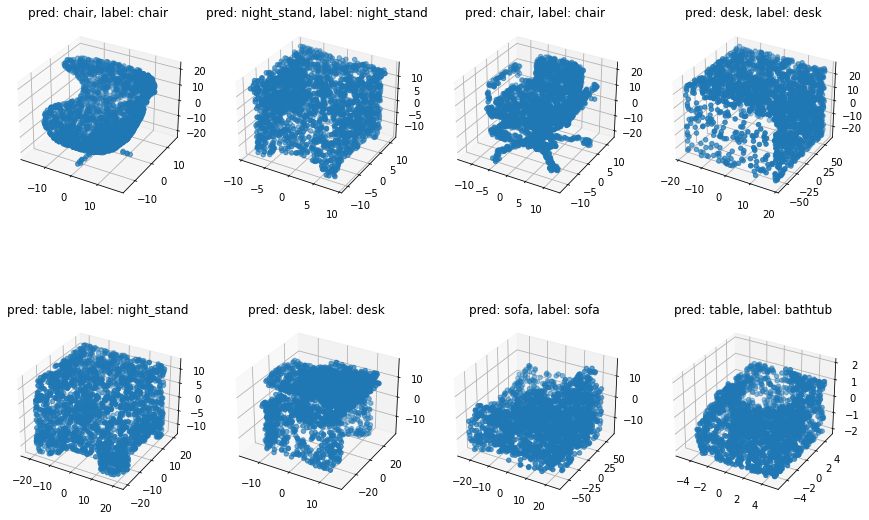

In [86]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

print(points.shape)
print(labels.shape)

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
#     ax.set_axis_off()
plt.show()
